In [2]:
from utils import extract_from_mnist, visualize_data
from train import prep_data,create_model,training_loop,eval_test,eval_train, plot_losses,visualize_weights_and_signs
from adv_attack import adv_attack,create_adv_test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import LabelEncoder


ModuleNotFoundError: No module named 'adv_attack'

# 1\ Logistic regression

### Data Extraction

In [2]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784')

# Convert labels to integers
mnist.target = mnist.target.astype(int)

# Filter the dataset for digits 7 and 3
filtered_data = pd.DataFrame(data=mnist.data, columns=mnist.feature_names)
filtered_data['target'] = mnist.target

# Reset the index of the filtered dataset
filtered_data = filtered_data.reset_index(drop=True)

# Print the shape of the filtered dataset
print("Filtered dataset shape:", filtered_data.shape)
print("Labels:", filtered_data['target'])


Filtered dataset shape: (70000, 785)
Labels: 0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: target, Length: 70000, dtype: int64


### Quick visualization

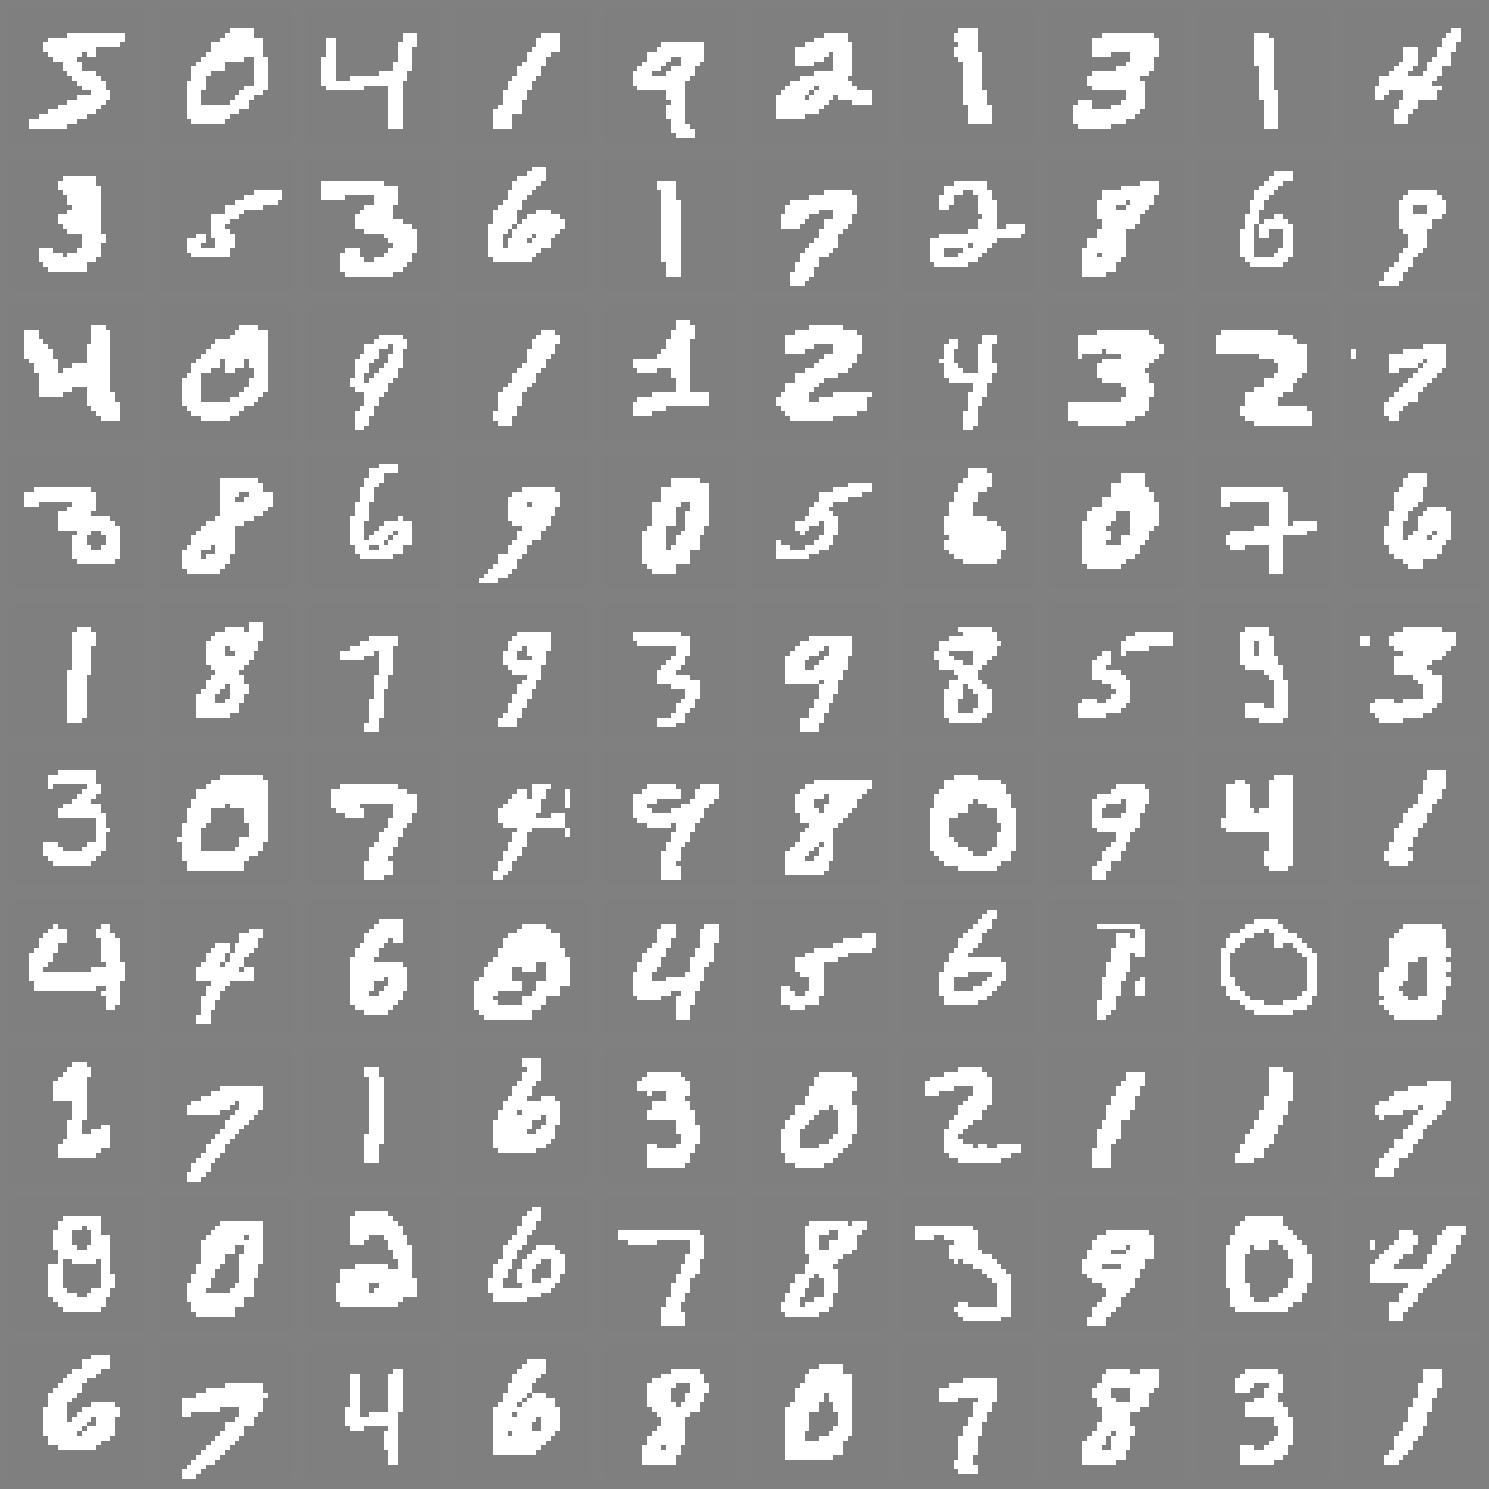

In [3]:
num_rows = 10
num_cols = 10
visualize_data(num_rows,num_cols,filtered_data) # to visualize the data

### Data preparation and model creation

In [4]:

# Assuming y is your target labels
y = filtered_data['target'].values


filtered_data_normalized = filtered_data.iloc[:, :-1].values / 255.0


# Convert data to PyTorch tensors
X_tensor = torch.tensor(filtered_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
num_classes = len(set(y))
print("Unique classes in target labels:", num_classes)

Unique classes in target labels: 10


In [5]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, 64, shuffle=True)

In [8]:
class RbfNet(nn.Module):
    def __init__(self, centers, num_class=10):
        super(RbfNet, self).__init__()
        self.centers = centers
        self.num_centers = centers.size(0)
        self.num_class = num_class
    
        self.linear = torch.nn.Linear(self.num_centers, self.num_class, bias=True)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)/10)

    def radial_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1)
        C = torch.exp(-self.beta.mul((A-B).pow(2).sum(2,keepdim=False).sqrt() ) )
        return C
    
    def forward(self, batches):
        radial_val = self.radial_fun(batches)
        class_score = self.linear(radial_val)
        return class_score


batch_images,batch_labels= next(iter(train_loader))

centers = batch_images

input_size = X_train_tensor.shape[1]
model = RbfNet(centers, num_class=10)
criterion = nn.CrossEntropyLoss()
optimizer =  optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)



### Training Loop and performance 

In [10]:
training_loss ,model_trained = training_loop(optimizer, model, criterion, X_train_tensor, y_train_tensor,num_epochs=20,batch_size=128)
# to train the model

Epoch [1/20], Loss: 1.9391
Epoch [2/20], Loss: 1.8612
Epoch [3/20], Loss: 1.6789
Epoch [4/20], Loss: 1.6687
Epoch [5/20], Loss: 1.6461
Epoch [6/20], Loss: 1.5953
Epoch [7/20], Loss: 1.5127
Epoch [8/20], Loss: 1.4532
Epoch [9/20], Loss: 1.4340
Epoch [10/20], Loss: 1.3724
Epoch [11/20], Loss: 1.3843
Epoch [12/20], Loss: 1.3639
Epoch [13/20], Loss: 1.2899
Epoch [14/20], Loss: 1.3399
Epoch [15/20], Loss: 1.3377
Epoch [16/20], Loss: 1.2970
Epoch [17/20], Loss: 1.1849
Epoch [18/20], Loss: 1.1018
Epoch [19/20], Loss: 1.2061
Epoch [20/20], Loss: 1.1938


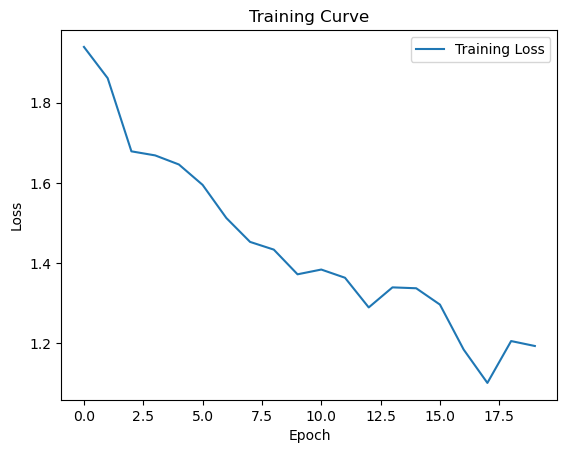

In [11]:
plot_losses(training_loss) # to plot the training loss

In [9]:
eval_train(X_train_tensor,y_train_tensor,model_trained) # to evaluate the model on the training set

Training Accuracy: 94.20%


### Weight Visualisation

In [10]:

visualize_weights_and_signs(model_trained) # to visualize the weights and signs of the model

RuntimeError: shape '[-1, 28, 28]' is invalid for input of size 640

# 2\ Logistic regression Vs Adversarial

### Test set for original images

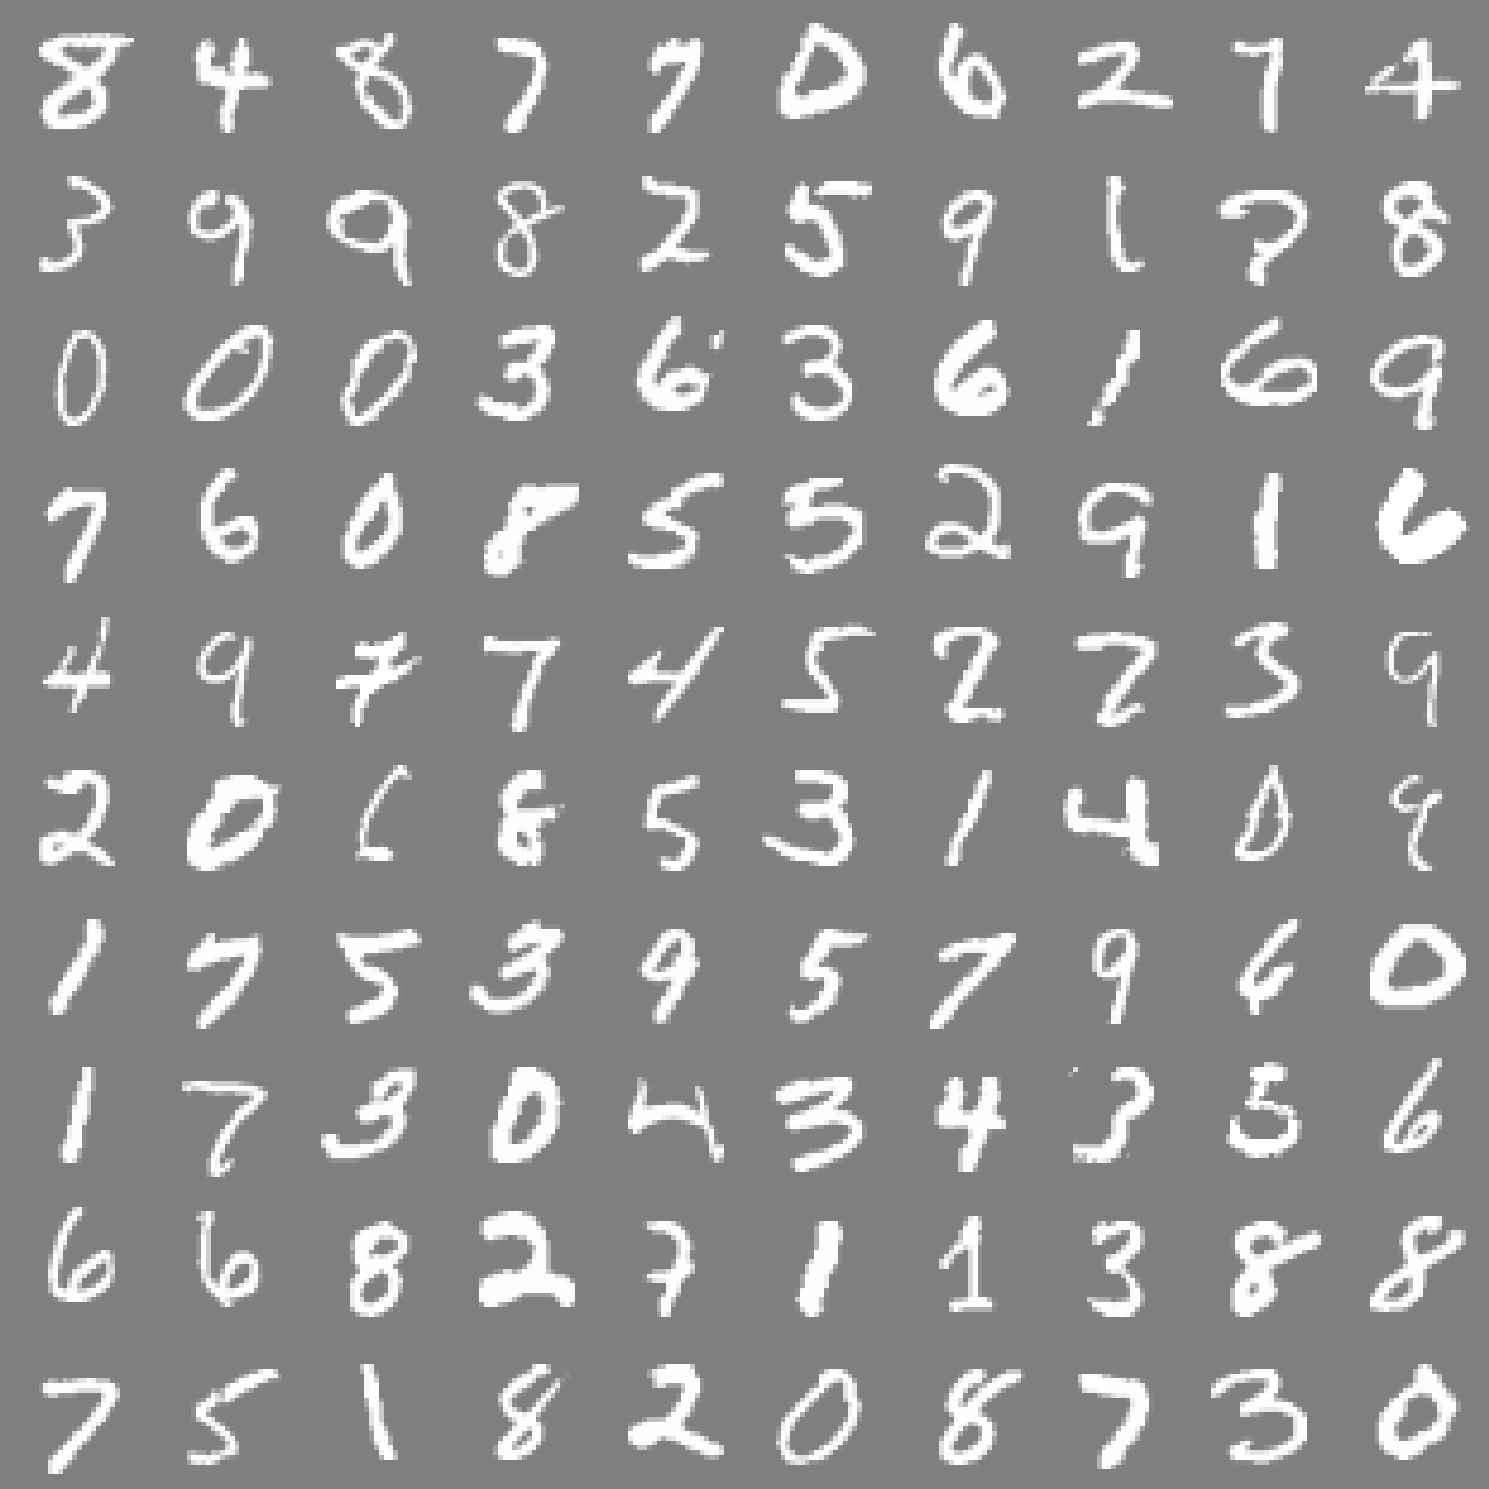

In [12]:

X_test_tensor2 = X_test_tensor.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor2) # to visualize the test data

### Evaluation of the model on the unaltered test set

In [13]:
eval_test(X_test_tensor,y_test_tensor,model)

Accuracy: 69.06%
Mean Confidence for All Examples: 0.3985
Mean Confidence for Incorrect Predictions: 0.2779


### Creation of the adversarial test set

In [14]:
eps = 0.25
X_test_tensor_adv = create_adv_test(model_trained,X_test_tensor,y_test_tensor,eps,criterion) # to create the adversarial test set

/home/spi-2019/Téléchargements/Tpworkspace/MLA_proj/adv_attack.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alt_im_norm =torch.tensor(alt_im, dtype=torch.float32)


### Visualization of the altered test set 

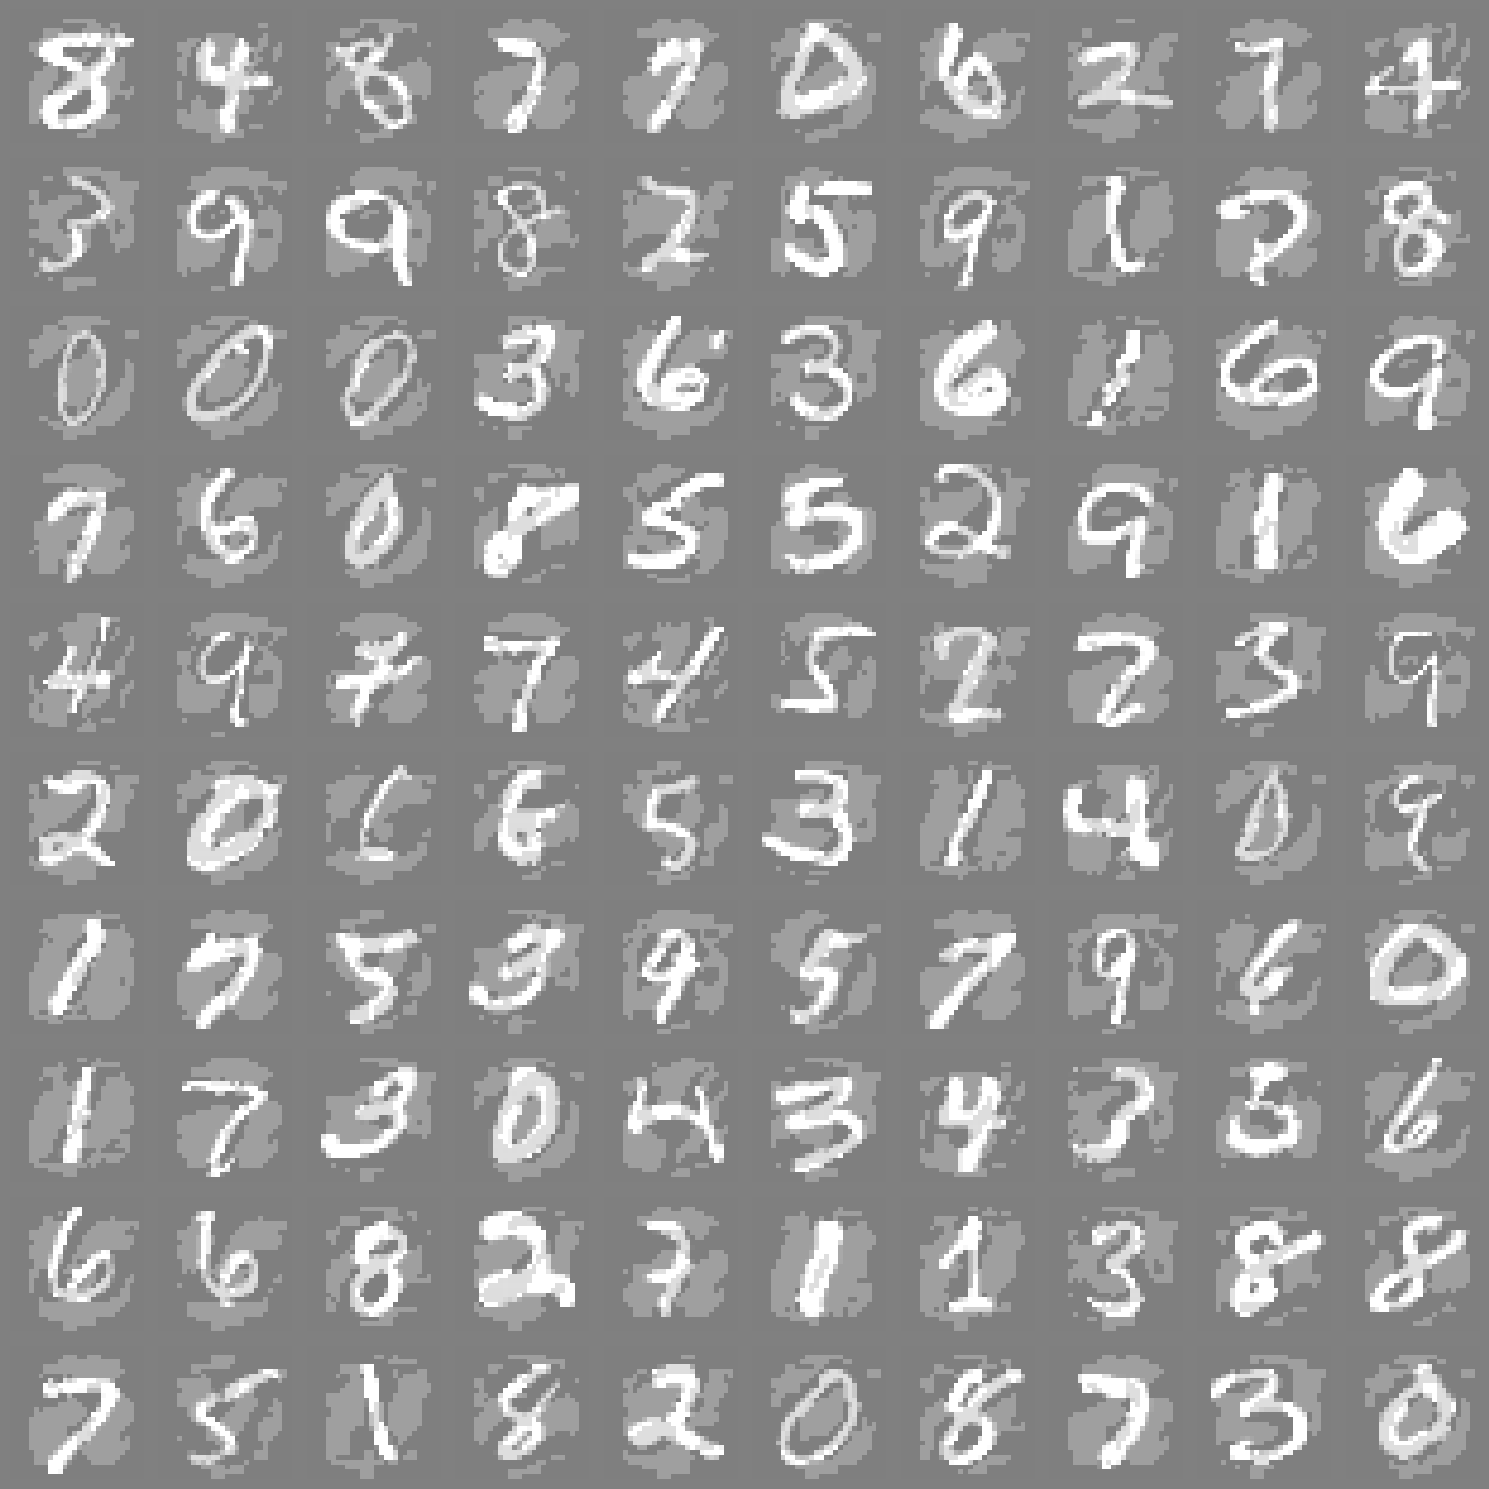

In [15]:
X_test_tensor_adv2 = X_test_tensor_adv.detach().numpy()
visualize_data(num_rows,num_cols,X_test_tensor_adv2) # to visualize the adversarial test set

### Evaluation of the model on the altered test set 

In [16]:
eval_test(X_test_tensor_adv,y_test_tensor,model)

Accuracy: 10.54%
Mean Confidence for Incorrect Predictions: 0.2818
